In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# PyTorch
In this notebook you will gain some hands-on experience with [PyTorch](https://pytorch.org/), one of the major frameworks for deep learning. To install PyTorch run `conda install pytorch torchvision cudatoolkit=10.1 -c pytorch`, with cudatoolkit set to whichever CUDA version you have installed. You can check this by running `nvcc --version`. If you do not have an Nvidia GPU you can run `conda install pytorch torchvision cpuonly -c pytorch` instead. However, in this case we recommend using [Google Colab](https://colab.research.google.com/).

You will start by re-implementing some common features of deep neural networks (dropout and batch normalization) and then implement a very popular modern architecture for image classification (ResNet) and improve its training loop.

# 1. Dropout
Dropout is a form of regularization for neural networks. It works by randomly setting activations (values) to 0, each one with equal probability `p`. The values are then scaled by a factor $\frac{1}{1-p}$ to conserve their mean.

Dropout effectively trains a pseudo-ensemble of models with stochastic gradient descent. During evaluation we want to use the full ensemble and therefore have to turn off dropout. Use `self.training` to check if the model is in training or evaluation mode.

In [2]:
class Dropout(nn.Module):
    """
    Dropout, as discussed in the lecture and described here:
    https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
    
    Args:
        p: float, dropout probability
    """
    def __init__(self, p):
        super().__init__()
        self.p = p
        
    def forward(self, input):
        """
        The module's forward pass.
        This has to be implemented for every PyTorch module.
        PyTorch then automatically generates the backward pass
        by dynamically generating the computational graph during
        execution.
        
        Args:
            input: PyTorch tensor, arbitrary shape

        Returns:
            PyTorch tensor, same shape as input
        """
        
        # TODO: Set values randomly to 0.

In [3]:
# Test dropout
test = torch.ones(10_000)
dropout = Dropout(0.5)
test_dropped = dropout(test)

# These assertions can in principle fail due to bad luck, but
# if implemented correctly they should almost always succeed.
assert np.isclose(test_dropped.sum().item(), 10_000, atol=400)
assert np.isclose((test_dropped > 0).sum().item(), 5_000, atol=200)

# 2. Batch normalization
Batch normalization is a trick use to smoothen the loss landscape and improve training. It is defined as the function
$$y = \frac{x - \mu_x}{\sigma_x + \epsilon} \cdot \gamma + \beta$$,
where $\gamma$ and $\beta$ and learnable parameters and $\epsilon$ is a some small number to avoid dividing by zero. The Statistics $\mu_x$ and $\sigma_x$ are taken separately for each feature. In a CNN this means averaging over the batch and all pixels.

In [4]:
class BatchNorm(nn.Module):
    """
    Batch normalization, as discussed in the lecture and similar to
    https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm1d
    
    Only uses batch statistics (no running mean for evaluation).
    Batch statistics are calculated for a single dimension.
    Gamma is initialized as 1, beta as 0.
    
    Args:
        num_features: Number of features to calculate batch statistics for.
    """
    def __init__(self, num_features):
        super().__init__()
        
        # TODO: Initialize the required parameters
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        
    def forward(self, input):
        """
        Batch normalization over the dimension C of (N, C, L).
        
        Args:
            input: PyTorch tensor, shape [N, C, L]
            
        Return:
            PyTorch tensor, same shape as input
        """
        eps = 1e-5
        
        # TODO: Implement the required transformation

In [5]:
# Tests the batch normalization implementation
torch.random.manual_seed(42)
test = torch.randn(8, 2, 4)

b1 = BatchNorm(2)
test_b1 = b1(test)

b2 = nn.BatchNorm1d(2, affine=False, track_running_stats=False)
test_b2 = b2(test)

assert torch.allclose(test_b1, test_b2, rtol=0.02)

# 3. ResNet
ResNet is the models that first introduced residual connections (a form of skip connections). It is a rather simple, but successful and very popular architecture. In this part of the exercise we will re-implement it step by step.

Note that there is also an [improved version of ResNet](https://arxiv.org/abs/1603.05027) with optimized residual blocks. Here we will implement the [original version](https://arxiv.org/abs/1512.03385) for CIFAR-10.

This is just a convenience function to make e.g. `nn.Sequential` more flexible. It is e.g. useful in combination with `x.squeeze()`.

In [6]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

We begin by implementing the residual blocks. The block is illustrated by this sketch:

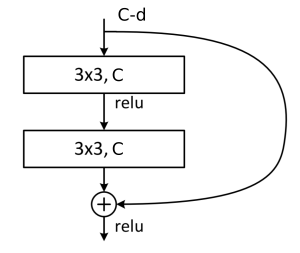

Note that we use 'SAME' padding, no bias, and batch normalization after each convolution.

In [7]:
class ResidualBlock(nn.Module):
    """
    The residual block used by ResNet.
    
    Args:
        in_channels: The number of channels (feature maps) of the incoming embedding
        out_channels: The number of channels after the first convolution
        stride: Stride size of the first convolution, used for downsampling
    """
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()        
        if stride > 1 or in_channels != out_channels:
            # Add strides in the skip connection and zeros for the new channels.
            self.skip = Lambda(lambda x: F.pad(x[:, :, ::stride, ::stride],
                                               (0, 0, 0, 0, 0, out_channels - in_channels),
                                               mode="constant", value=0))
        else:
            self.skip = nn.Sequential()
            
        # TODO: Initialize the required layers
        
    def forward(self, input):
        # TODO: Execute the required layers and functions

Next we implement a stack of residual blocks for convenience. The first layer in the block is the one changing the number of channels and downsampling. You can use `nn.ModuleList` to use a list of child modules.

In [8]:
class ResidualStack(nn.Module):
    """
    A stack of residual blocks.
    
    Args:
        in_channels: The number of channels (feature maps) of the incoming embedding
        out_channels: The number of channels after the first layer
        stride: Stride size of the first layer, used for downsampling
        num_blocks: Number of residual blocks
    """
    
    def __init__(self, in_channels, out_channels, stride, num_blocks):
        super().__init__()
        
        # TODO: Initialize the required layers (blocks)
        
    def forward(self, input):
        # TODO: Execute the layers (blocks)

Now we are finally ready to implement the full model! To do this, use the `nn.Sequential` API and carefully read the following paragraph from the paper (Fig. 3 is not important):

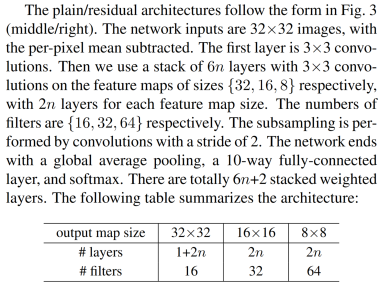

Note that a convolution layer is always convolution + batch norm + activation (ReLU), that each ResidualBlock contains 2 layers, and that you might have to `squeeze` the embedding before the dense (fully-connected) layer.

In [9]:
n = 5
num_classes = 10

# TODO: Implement ResNet via nn.Sequential

Next we need to initialize the weights of our model.

In [10]:
def initialize_weight(module):
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)
        
resnet.apply(initialize_weight);

# 4. Training
So now we have a shiny new model, but that doesn't really help when we can't train it. So that's what we do next.

First we need to load the data. Note that we split the official training data into train and validation sets, because you must not look at the test set until you are completely done developing your model and report the final results. Some people don't do this properly, but you should not copy other people's bad habits.

In [11]:
class CIFAR10Subset(torchvision.datasets.CIFAR10):
    """
    Get a subset of the CIFAR10 dataset, according to the passed indices.
    """
    def __init__(self, *args, idx=None, **kwargs):
        super().__init__(*args, **kwargs)
        
        if idx is None:
            return
        
        self.data = self.data[idx]
        targets_np = np.array(self.targets)
        self.targets = targets_np[idx].tolist()

We next define transformations that change the images into PyTorch tensors, standardize the values according to the precomputed mean and standard deviation, and provide data augmentation for the training set.

In [12]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    normalize,
])
transform_eval = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [13]:
ntrain = 45_000
train_set = CIFAR10Subset(root='./data', train=True, idx=range(ntrain),
                          download=True, transform=transform_train)
val_set = CIFAR10Subset(root='./data', train=True, idx=range(ntrain, 50_000),
                        download=True, transform=transform_eval)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_eval)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [14]:
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(train_set, batch_size=128,
                                                   shuffle=True, num_workers=2,
                                                   pin_memory=True)
dataloaders['val'] = torch.utils.data.DataLoader(val_set, batch_size=128,
                                                 shuffle=False, num_workers=2,
                                                 pin_memory=True)
dataloaders['test'] = torch.utils.data.DataLoader(test_set, batch_size=128,
                                                  shuffle=False, num_workers=2,
                                                  pin_memory=True)

Next we push the model to our GPU (if there is one).

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
resnet.to(device);

Next we define a helper method that does one epoch of training or evaluation. We have only defined training here, so you need to implement the necessary changes for evaluation!

In [16]:
def run_epoch(model, optimizer, dataloader, train):
    """
    Run one epoch of training or evaluation.
    
    Args:
        model: The model used for prediction
        optimizer: Optimization algorithm for the model
        dataloader: Dataloader providing the data to run our model on
        train: Whether this epoch is used for training or evaluation
        
    Returns:
        Loss and accuracy in this epoch.
    """
    # TODO: Change the necessary parts to work correctly during evaluation (train=False)
    
    device = next(model.parameters()).device
    
    # Set model to training mode (for e.g. batch normalization, dropout)
    model.train()

    epoch_loss = 0.0
    epoch_acc = 0.0

    # Iterate over data
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(True):
            pred = model(xb)
            loss = F.cross_entropy(pred, yb)
            top1 = torch.argmax(pred, dim=1)
            ncorrect = torch.sum(top1 == yb)

            loss.backward()
            optimizer.step()

        # statistics
        epoch_loss += loss.item()
        epoch_acc += ncorrect.item()
    
    epoch_loss /= len(dataloader)
    epoch_acc /= len(dataloader)
    return epoch_loss, epoch_acc

Next we implement a method for fitting (training) our model. For many models early stopping can save a lot of training time. Your task is to add early stopping to the loop (based on validation accuracy)! And don't forget to save the best model parameters according to validation accuracy. You will need `copy.deepcopy` and the `state_dict` for this.

In [17]:
def fit(model, optimizer, lr_scheduler, dataloaders, max_epochs, patience):
    """
    Fit the given model on the dataset.
    
    Args:
        model: The model used for prediction
        optimizer: Optimization algorithm for the model
        lr_scheduler: Learning rate scheduler that improves training
                      in late epochs with learning rate decay
        dataloaders: Dataloaders for training and validation
        max_epochs: Maximum number of epochs for training
        patience: Number of epochs to wait with early stopping the
                  training if validation loss has decreased
                  
    Returns:
        Loss and accuracy in this epoch.
    """
    
    best_acc = 0
    curr_patience = 0
    
    for epoch in range(max_epochs):
        train_loss, train_acc = run_epoch(model, optimizer, dataloaders['train'], train=True)
        lr_scheduler.step()
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, train loss: {train_loss:.2e}, accuracy: {train_acc * 100:.2f}%")
        
        val_loss, val_acc = run_epoch(model, None, dataloaders['val'], train=False)
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, val loss: {val_loss:.2e}, accuracy: {val_acc * 100:.2f}%")
        
        # TODO: Add early stopping and save the best weights (in best_model_weights)
    
    model.load_state_dict(best_model_weights)

In most cases you should just use the Adam optimizer for training, because it works well out of the box. However, a well-tuned SGD (with momentum) will in most cases outperform Adam. And since the original paper gives us a well-tuned SGD we will just use that.

In [18]:
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)

# Fit model
fit(resnet, optimizer, lr_scheduler, dataloaders, max_epochs=200, patience=50)

Epoch   1/200, train loss: 1.7e-02, accuracy: 23.57%
Epoch   1/200, val loss: 1.3e-02, accuracy: 38.72%
Epoch   2/200, train loss: 1.2e-02, accuracy: 44.79%
Epoch   2/200, val loss: 1.1e-02, accuracy: 51.06%
Epoch   3/200, train loss: 9.3e-03, accuracy: 57.11%
Epoch   3/200, val loss: 9.2e-03, accuracy: 59.40%
Epoch   4/200, train loss: 7.5e-03, accuracy: 66.02%
Epoch   4/200, val loss: 8.3e-03, accuracy: 65.08%
Epoch   5/200, train loss: 6.3e-03, accuracy: 71.90%
Epoch   5/200, val loss: 7.7e-03, accuracy: 69.28%
Epoch   6/200, train loss: 5.5e-03, accuracy: 75.68%
Epoch   6/200, val loss: 5.8e-03, accuracy: 76.08%
Epoch   7/200, train loss: 5.0e-03, accuracy: 77.67%
Epoch   7/200, val loss: 1.1e-02, accuracy: 64.12%
Epoch   8/200, train loss: 4.6e-03, accuracy: 79.82%
Epoch   8/200, val loss: 5.7e-03, accuracy: 78.02%
Epoch   9/200, train loss: 4.3e-03, accuracy: 80.78%
Epoch   9/200, val loss: 5.4e-03, accuracy: 78.16%
Epoch  10/200, train loss: 4.1e-03, accuracy: 82.24%
Epoch  10/2

Once the model is trained we run it on the test set to obtain our final accuracy.
Note that we can only look at the test set once, everything else would lead to overfitting. So you _must_ ignore the test set while developing your model!

In [19]:
test_loss, test_acc = run_epoch(resnet, None, dataloaders['test'], train=False)
print(f"Test loss: {test_loss:.1e}, accuracy: {test_acc * 100:.2f}%")

Test loss: 2.8e-03, accuracy: 92.07%


That's almost what was reported in the paper (92.49%) and we didn't even train on the full training set.

# Optional task: Squeeze out all the juice!

Can you do even better? Have a look at [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/) and at the [EfficientNet architecture](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html) we discussed in the lecture. Play around with the possibilities PyTorch offers you and see how close you can get to the [state of the art on CIFAR-10](https://paperswithcode.com/sota/image-classification-on-cifar-10).

Hint: You can use [Google Colab](https://colab.research.google.com/) to access some free GPUs for your experiments.